# Эксперименты по восстановлению профилей дисперсий в трех направлениях для NGC1167 (UGC2487)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import poly1d, polyfit, power
import scipy.optimize
from math import *
from IPython.display import HTML
from IPython.display import Image
import os
import PIL as pil
import heapq
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.cm as cm
import scipy.interpolate as inter
%matplotlib inline

#Размер изображений
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 12

#Наклон галактики по данным Засова
incl=36.0

# Масштаб пк/секунда из NED
scale=321

#Эффективный радиус балджа
r_eb = 6.7

cos_i, sin_i = cos(incl * pi / 180), sin(incl * pi / 180)

In [2]:
os.chdir("C:\\science\\2FInstability\\data\\ngc1167")

[]

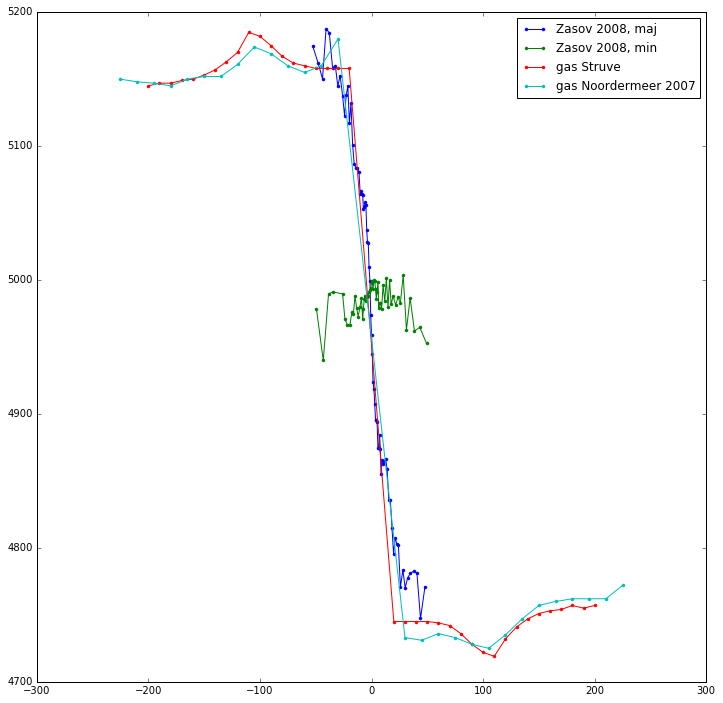

In [3]:
# Данные по звездной кинематике Засова 2012 вдоль большей полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_maZ.dat", float)
r_ma, vel_ma, e_vel_ma, sig_ma, e_sig_ma = zip(*zasov_raw_data)

# Данные по звездной кинематике Засова 2012 вдоль малой полуоси, не исправленные за наклон 
zasov_raw_data = np.loadtxt("v_stars_miZ.dat", float)
r_mi, vel_mi, e_vel_mi, sig_mi, e_sig_mi = zip(*zasov_raw_data)

# Данные по кинематике газа Struve, WSRT (не исправлено за наклон)
wsrt_raw_data = np.loadtxt("v_gas_WSRT.dat", float)
r_wsrt, vel_wsrt, e_vel_wsrt = zip(*wsrt_raw_data)

# Данные по кинематике газа Noordermee 2007, WSRT (не исправлено за наклон?)
noord_raw_data = np.loadtxt("v_gas_noord.dat", float)
r_noord, vel_noord, e_vel_noord = zip(*noord_raw_data)

plt.plot(r_ma, vel_ma, '.-', label="Zasov 2008, maj")
plt.plot(r_mi, vel_mi, '.-', label="Zasov 2008, min")
plt.plot(r_wsrt, vel_wsrt, '.-', label="gas Struve")
plt.plot(r_noord, vel_noord, '.-', label="gas Noordermeer 2007")
plt.legend()
plt.plot()

[]

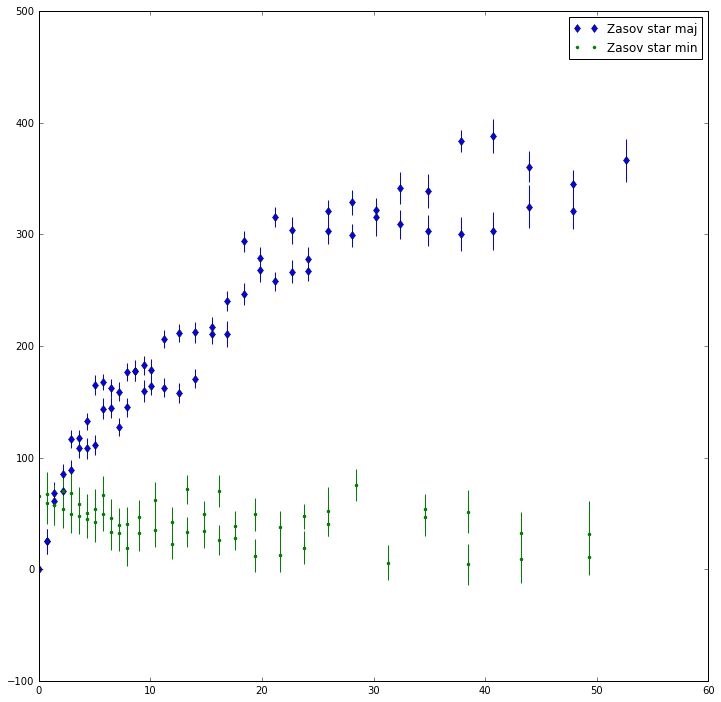

In [4]:
def incline_velocity(v, angle):
    return v / sin(angle * pi / 180)

# Переносит центр в (r0,v0) и перегибает кривую вращения, 
# а также исправляет за наклон если необходимо
def correct_rotation_curve(rdata, vdata, dvdata, r0, v0, incl):
    rdata_tmp = [abs(r-r0) for r in rdata]
    vdata_tmp = [incline_velocity(abs(v-v0), incl) for v in vdata]
    data = zip(rdata_tmp, vdata_tmp, dvdata)
    data.sort()
    return zip(*data)

r_ma_b, vel_ma_b, e_vel_b = correct_rotation_curve(r_ma, vel_ma, e_vel_ma,  0.0, 4959.3, incl)
r_mi_b, vel_mi_b, e_vel_mi_b = correct_rotation_curve(r_mi, vel_mi, e_vel_mi,  0.0, 4959.3, incl)

plt.plot(r_ma_b, vel_ma_b, 'd', label = 'Zasov star maj')
plt.errorbar(r_ma_b, vel_ma_b, yerr=e_vel_b, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_b, vel_mi_b, '.', label = 'Zasov star min', color='green')
plt.errorbar(r_mi_b, vel_mi_b, yerr=e_vel_mi_b, fmt='.', marker='.', mew=0, color='green')
plt.legend()
plt.plot()

В дальнейшем используем только засовские данные по звездам по большой полуоси, приблизим их полиномом. 

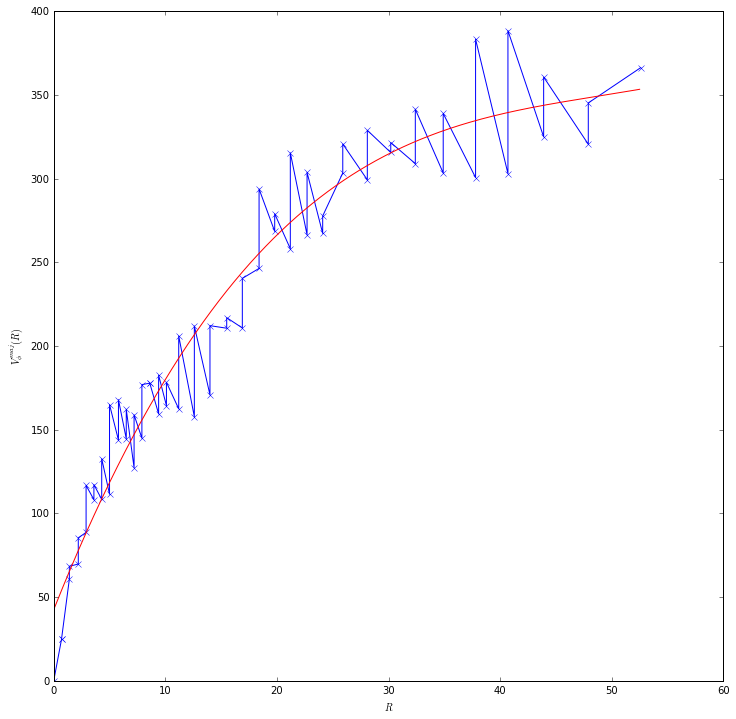

In [5]:
poly_star = poly1d(polyfit(r_ma_b, vel_ma_b, deg=3))

plt.plot(r_ma_b, vel_ma_b, 'x-', color='blue', markersize=6)
test_points = np.arange(0.0, max(r_ma_b), 0.1)
plt.plot(test_points, poly_star(test_points), '-', color='red')
plt.xlabel('$R$'); plt.ylim(0)
plt.ylabel('$V^{maj}_{\phi}(R)$')
plt.show()

Кривая вращения нам нужна для нахождения соотношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, которое описывается уравнением ${\displaystyle \sigma_{\varphi}^{2}/\sigma_{R}^{2}=0.5\left(1+\frac{R}{\bar{v}_{\varphi}}\frac{d\bar{v}_{\varphi}}{dR}\right)}$ (Binney & Tremaine, 1987) и приближается гладко функцией $f=0.5(1+e^{-R/R_{0}}),$ где $R_{0}$ --- характерный масштаб. 

${\bf Примечание:}$ Такое приближение оправдано следующими соображениями. Для равновесного диска верно уравнение, описанное выше. Для твердотельного участка вращения в центральных областях выражение в скобках равно 2, а $\sigma_{\varphi}^{2}/\sigma_{R}^{2}=1$. На плоском участке кривой вращения на периферии диска $\sigma_{\varphi}^{2}/\sigma_{R}^{2}\thickapprox0.5$. Функция $f$ как раз аппроксимирует такое поведение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$.

Изобразим получившийся профиль $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$, вычисляемый через производную полинома:

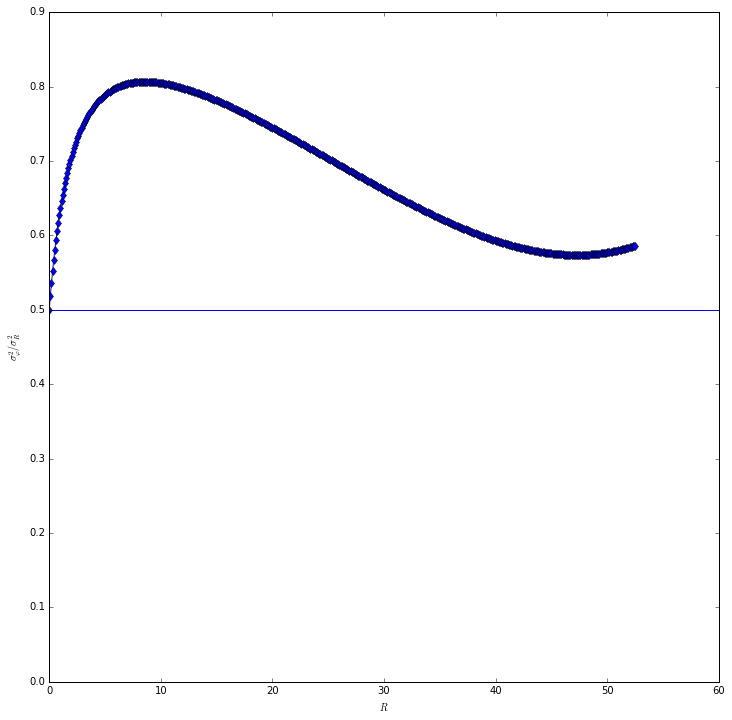

In [6]:
def sigPhi_to_sigR_real(R):
        return 0.5 * (1 + R*poly_star.deriv()(R) / poly_star(R))

plt.plot(test_points, [sigPhi_to_sigR_real(R) for R in test_points], 'd-', color='blue')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.xlabel('$R$')
plt.ylabel(r"$\sigma_{\varphi}^2/\sigma_{R}^2$")
plt.ylim(0)
plt.show()

Найдем теперь характерный масштаб $f=0.5(1+e^{-R/R_{0}})$:

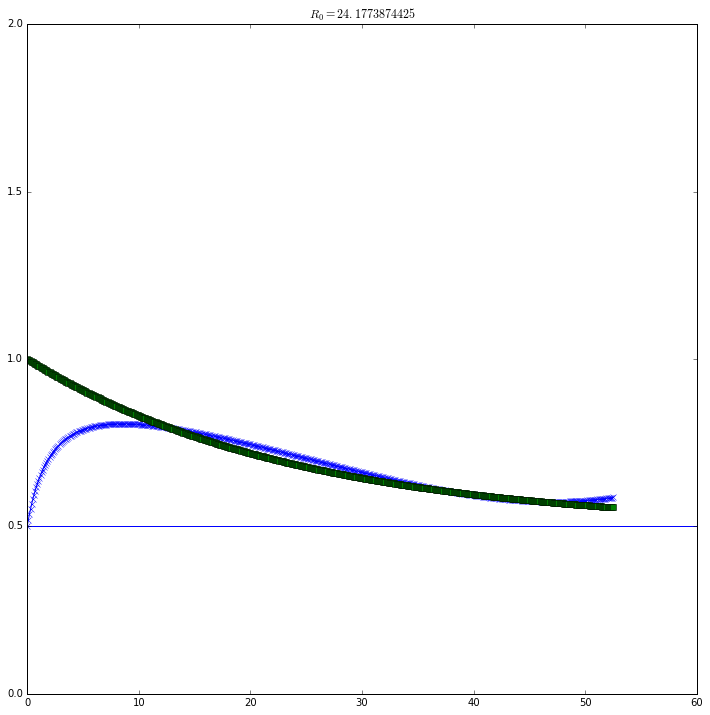

In [7]:
def f(R, Ro):
    return 0.5*(1 + np.exp( -R/Ro ))

xdata = test_points
ydata = sigPhi_to_sigR_real(xdata)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(f, xdata, ydata, p0=[1.0])
Ro = popt[0]

plt.plot(xdata, ydata, 'x-')
plt.plot(xdata, [f(p, Ro) for p in xdata], 's')
plt.axhline(y=0.5)
plt.axhline(y=0.0)
plt.title('$R_{0} = %s $' % Ro)
plt.ylim(0, 2)
plt.show()

Теперь знаем значение отношения $\sigma_{\varphi}^{2}/\sigma_{R}^{2}$ в любой точке, заведем соответствующую функцию:

In [8]:
def sigPhi_to_sigR(R):
    return sqrt(f(R, Ro))

Построим графики дисперсий скоростей на луче зрения вдоль большой и малой оси ($\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$):

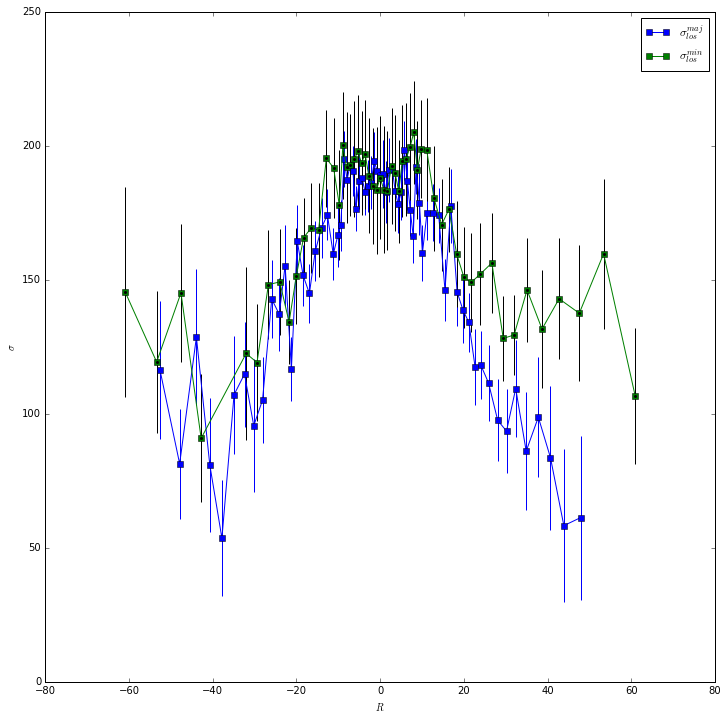

In [9]:
# Исправляем значения вдоль малой оси на синус угла:    
def correct_min(R):    
    return R / cos(incl * pi / 180) 

r_mi_extend = map(correct_min, r_mi)
    
plt.plot(r_ma, sig_ma, 's-', label='$\sigma_{los}^{maj}$')
plt.errorbar(r_ma, sig_ma, yerr=e_sig_ma, fmt='.', marker='.', mew=0, color='blue')
plt.plot(r_mi_extend, sig_mi, 's-', label='$\sigma_{los}^{min}$')
plt.errorbar(r_mi_extend, sig_mi, yerr=e_sig_mi, fmt='.', marker='.', mew=0, color='black')
plt.xlabel('$R$')
plt.ylabel('$\sigma$')
plt.legend()
plt.show()

Перегнем и приблизим полиномами:

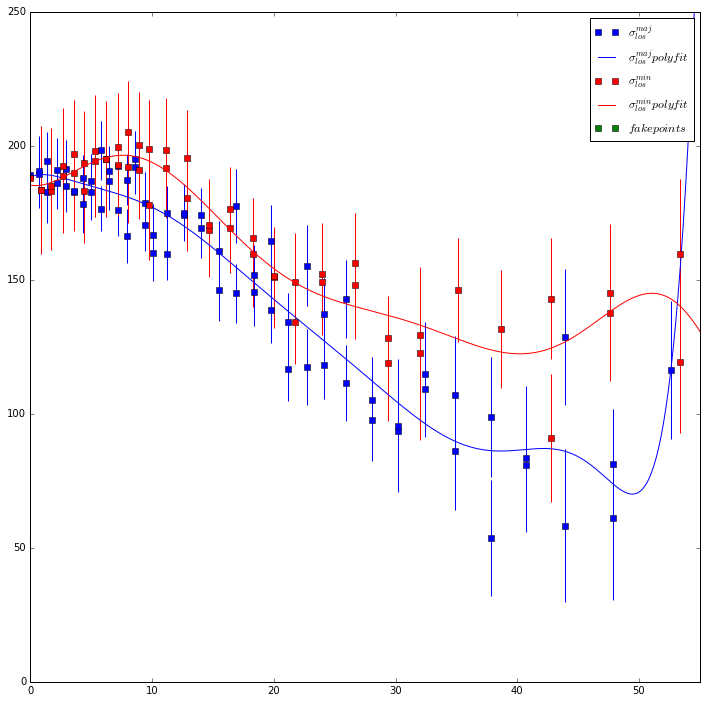

In [10]:
bind_curve = lambda p: (abs(p[0]), abs(p[1]), p[2])
sig_maj_data = zip(r_ma, sig_ma, e_sig_ma)
sig_maj_data = map(bind_curve, sig_maj_data)
sig_maj_data.sort()
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

poly_sig_maj = poly1d(polyfit(radii_maj, sig_maj_p, deg=9))

sig_min_data = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data = map(bind_curve, sig_min_data)
sig_min_data.sort()
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

# Добавляем лишние точки чтобы протянуть дальше
num_fake_points = 10; expscale = 200.0
# fake_radii, fake_sig = zip(*[(31.0 + i, 115*exp(- i / expscale )) for i in range(1, num_fake_points+1)])
fake_radii, fake_sig = (),()

poly_sig_min = poly1d(polyfit(radii_min + fake_radii, sig_min_p + fake_sig, deg=9))

points = np.arange(0, max(radii_min), 0.1)
plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj} polyfit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, poly_sig_min(points), label = '$\sigma_{los}^{min} polyfit$', color='red')
plt.plot(fake_radii, fake_sig, 'bs', color='green', label='$fake points$')
plt.legend()
plt.ylim(0,250)
plt.xlim(0,55)
plt.show()

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [11]:
%%javascript 
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [12]:
sig_maj_data = zip(r_ma[:-1], sig_ma[:-1], e_sig_ma[:-1])
sig_maj_data = map(bind_curve, sig_maj_data)
sig_maj_data.sort()
radii_maj1, sig_maj_p1, e_sig_maj_p1 = zip(*sig_maj_data) 

sig_min_data = zip(r_mi_extend, sig_mi, e_sig_mi)
sig_min_data = map(bind_curve, sig_min_data)
sig_min_data.sort()
radii_min1, sig_min_p1, e_sig_min_p1 = zip(*sig_min_data) 

points = np.arange(0, max(radii_min), 0.1)

# 7. r_ef, sig_R_0=spline(r_ef)

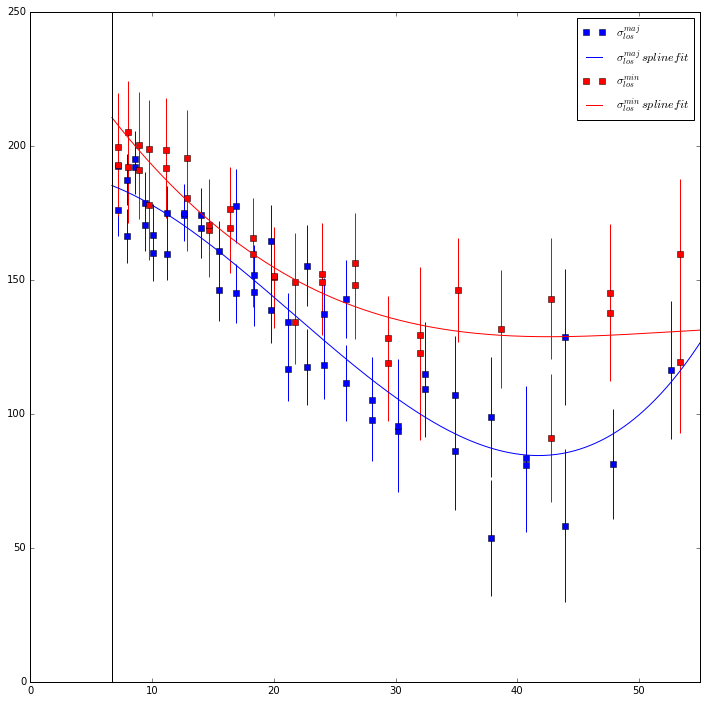

In [13]:
# Граница. по которой обрезаем
cutted = r_eb

sig_maj_data = zip(radii_maj1, sig_maj_p1, e_sig_maj_p1)
sig_maj_data = filter(lambda l: l[0] > cutted, sig_maj_data)
radii_maj, sig_maj_p, e_sig_maj_p = zip(*sig_maj_data) 

sig_min_data = zip(radii_min1, sig_min_p1, e_sig_min_p1)
sig_min_data = filter(lambda l: l[0] > cutted, sig_min_data)
radii_min, sig_min_p, e_sig_min_p = zip(*sig_min_data) 

points = np.arange(cutted, max(radii_min), 0.1)

def w(arr):
    return map(lambda l: 1/(1. + l**2), arr)

spl_maj = inter.UnivariateSpline(radii_maj[::-1], sig_maj_p[::-1], k=3, s=10000., w=w(e_sig_maj_p))
spl_min = inter.UnivariateSpline(radii_min[::-1], sig_min_p[::-1], k=3, s=10000., w=w(e_sig_min_p))

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='.', marker='.', mew=0, color='blue')
plt.plot(points, spl_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
plt.plot(radii_min, sig_min_p, 's', label='$\sigma_{los}^{min}$', color='red')
plt.errorbar(radii_min, sig_min_p, yerr=e_sig_min_p, fmt='.', marker='.', mew=0, color='red')
plt.plot(points, spl_min(points), label = '$\sigma_{los}^{min}\, splinefit$', color='red')
plt.axvline(x=cutted, color='black')
plt.legend()
plt.ylim(0,250)
plt.xlim(0,55)
plt.show()

poly_sig_maj = spl_maj
poly_sig_min = spl_min

In [14]:
#Значение sig_los_min в 0
sig_min_0 = poly_sig_min(cutted)
print sig_min_0

210.677489398


И восстановим профили $\sigma_{los}^{maj}$ и $\sigma_{los}^{min}$. Связь профилей описывается следующими уравнениями: $$\sigma_{los,maj}^2=\sigma_{\varphi}^2\sin^2i+\sigma_Z^2\cos^2i$$ $$\sigma_{los,min}^2=\sigma_R^2\sin^2i+\sigma_Z^2\cos^2i$$

In [15]:
# def sig_maj_exp(R):
#     return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

# def sig_min_exp(R):
#     return sqrt(sigR_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)


def sig_maj_exp(R):
    return sig_R_0*poly_sig_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR_real(R) * sin_i**2 + alpha**2 * cos_i**2)
#     tmp = sigPhi_to_sigR_real(R) * sin_i**2 + alpha**2 * cos_i**2
#     if tmp > 0:
#         return sig_R_0*poly_sig_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR_real(R) * sin_i**2 + alpha**2 * cos_i**2)
#     else:
#         return -1000000
#     return sig_R_0*spl_min(R)/sig_min_0 * sqrt(sigPhi_to_sigR(R)**2 * sin_i**2 + alpha**2 * cos_i**2)
#     return sqrt(sigPhi_exp(R)**2 * sin(incl*pi/180)**2 + sigZ_exp(R)**2 * cos(incl*pi/180)**2)

def sig_min_exp(R):
    return sig_R_0*poly_sig_min(R)/sig_min_0 * sqrt(sin_i**2 + alpha**2 * cos_i**2)
#     if R >= cutted:
#         return sig_R_0*poly_sig_min(R)/sig_min_0 * sqrt(sin_i**2 + alpha**2 * cos_i**2)
#     else:
#         return -1000000


Теперь то, с чего надо было начинать - построим картинки для разных значений $\alpha$ и $\sigma_{R,0}$. Для того, чтобы найти где минимум, попробуем построить просто двумерные карты $\chi^2$ для разных $\sigma_{R,0}$  $\alpha$: (это очень долго, так что пересчитывать в крайнем случае) 

In [16]:
alphas = np.arange(0.01, 1.2, 0.03)
sigmas = np.arange(100.0, 400, 3.)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

def compute_chi2_maps(alphas=(), sigmas=()):
    '''Вычисляем все изображения, чтобы потом только настройки менять'''
    image_min = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj = np.random.uniform(size=(len(sigmas), len(alphas)))
    image = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
            sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
            sqerr_sum = 0.5*sqerr_maj+0.5*sqerr_min
            image[i][j] = sqerr_sum
            image_maj[i][j] = sqerr_maj
            image_min[i][j] = sqerr_min
    return image, image_maj, image_min
    
image, image_maj, image_min = compute_chi2_maps(alphas=alphas, sigmas=sigmas)

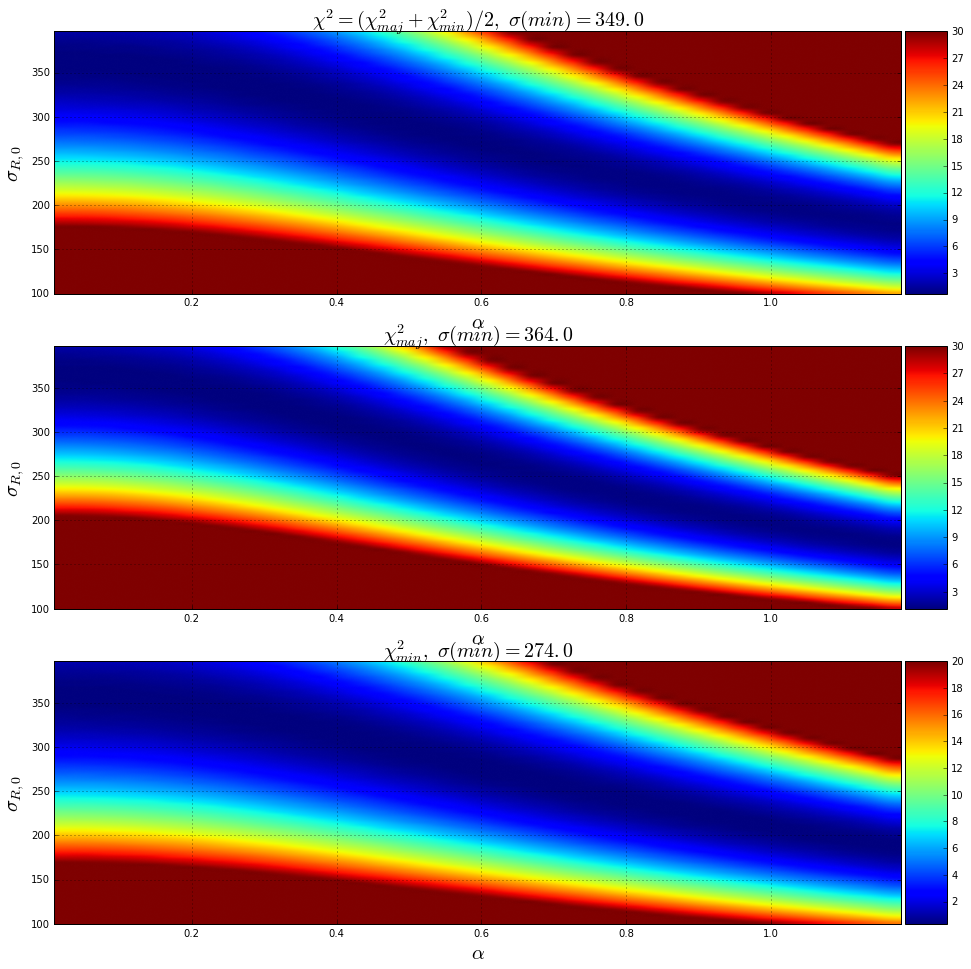

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_chi2_map(image, ax, log_scale=False, title='$\chi^2$', is_contour=False, vmax=0.):
    '''Рисуем получившиеся карты.
    Colormaps: http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps'''
    if image is not None:
        if log_scale:
            image_log = np.apply_along_axis(np.log, 1, image)
            vmax = image_log.max()
        else:
            image_log = image
        if is_contour:
            norm = plt.cm.colors.Normalize(vmax=image.max(), vmin=-image.max())
            cmap = plt.cm.PRGn
#             levels = np.concatenate([np.array([image_log.min()*1.1,]), np.linspace(start=image_log.min(), stop=vmax, num=10)])
            levels = np.linspace(start=image_log.min()+0.05, stop=vmax, num=10)
            levels = sorted(levels)
            cset=ax.contour(image_log, levels, hold='on', colors = 'k', origin='lower', 
                            extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
            ax.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
        im = ax.imshow(image_log, cmap='jet', vmin=image_log.min(), vmax=vmax, interpolation='spline16', 
                   origin="lower", extent=[alphas[0], alphas[-1],sigmas[0],sigmas[-1]], aspect="auto")
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)
        min_sigma = sigmas[int(np.where(image == image.min())[0])]        
        ax.set_title(title + '$,\ \sigma(min)=%s$' % min_sigma, size=20.)
        ax.set_ylabel('$\sigma_{R,0}$', size=20.)
        ax.set_xlabel(r'$\alpha$', size=20.)
        ax.grid(True)
 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[16,16])
plot_chi2_map(image, axes[0], log_scale=False, title='$\chi^2 = (\chi^2_{maj} + \chi^2_{min})/2$', is_contour=False, vmax=30.)
plot_chi2_map(image_maj, axes[1], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=30.)
plot_chi2_map(image_min, axes[2], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=20.)
plt.show()

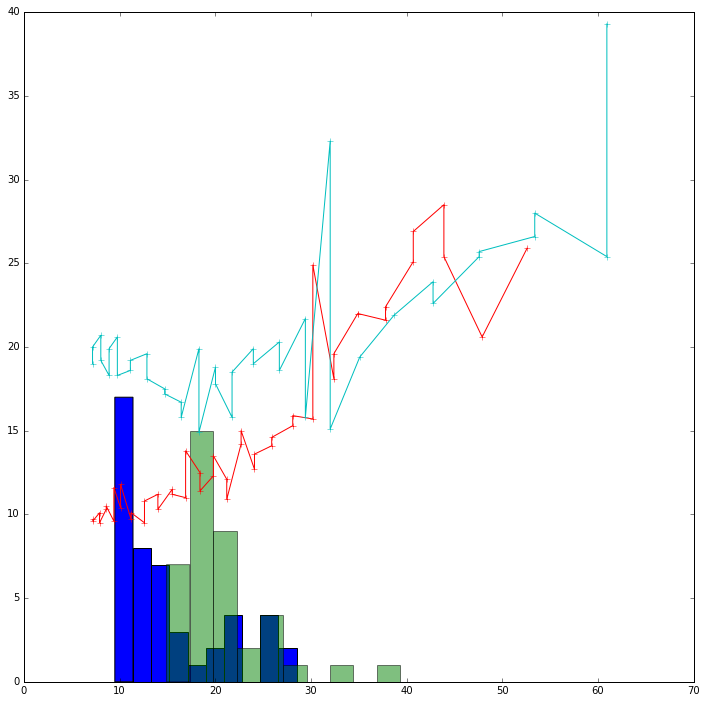

In [18]:
plt.hist(e_sig_maj_p)
plt.hist(e_sig_min_p, alpha=0.5)
plt.plot(radii_maj, e_sig_maj_p, '+-')
plt.plot(radii_min, e_sig_min_p, '+-')
plt.show()

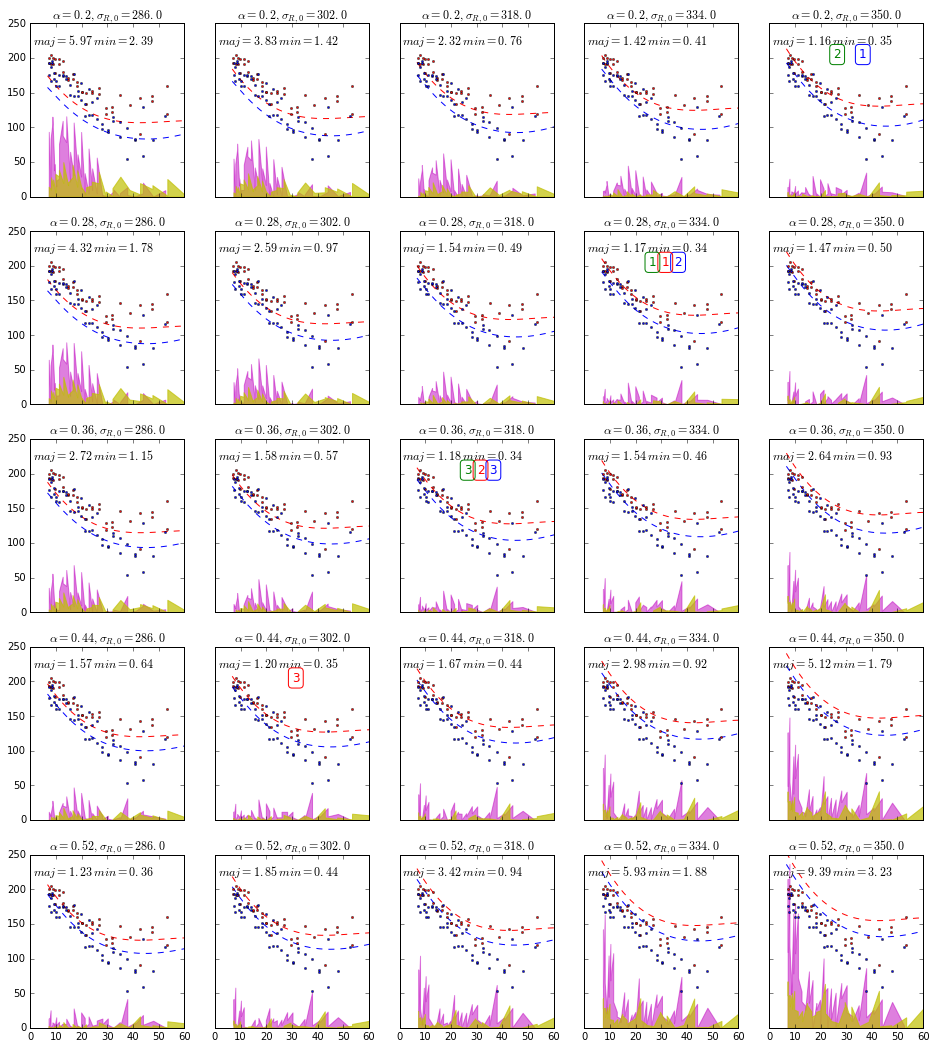

In [19]:
# Перебор alpha
alphas = np.arange(0.2, 0.6, 0.08)

# Перебор sig_R_0
sigmas = np.arange(286., 366., 16.)

# Те картинки, на которые стоит обратить особое внимание
good_pics = []


def plot_ranges(sigmas_range, alphas_range, good_pics=[], calc_chi=False, best_err=3):
    '''
    Для всех предложенных вариантов sigR и alpha
    рисует графики исходных и восстановленных дисперсий скоростей los.
    Если calc_chi = True, то также считает ошибку по наблюдаемым точкам.
    Если ошибка считается, то отмечаются best_err лучших (наименьших) результата.
    Синий - для большой оси, красный - малой, зеленый - полусумма.
    Изменяет глобальные значения sig_R_0 и alpha!'''
    nrows = alphas.size
    ncols = sigmas.size
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=[16,18])
    plt_index = 0
    sqerr_majs, sqerr_mins, sqerr_mean = [],[],[]
    for al in alphas_range:
        for si in sigmas_range:
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            ax = axes[plt_index/ncols, plt_index % ncols]
            ax.set_title(r'$\alpha = %s, \sigma_{R,0}=%s$' % (al,si))
#             ax.plot(points, poly_sig_maj(points), '-', color='blue')
            ax.plot(points, [sig_maj_exp(Rr) for Rr in points], '--', color='blue')
#             ax.plot(points, poly_sig_min(points), '-', color='red')
            ax.plot(points, [sig_min_exp(R) for R in points], '--', color='red')
            if calc_chi:
                sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(p[0]) for p in sig_maj_data])
                sqerr_min = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(p[0]) for p in sig_min_data])
#                 sqerr_maj = sum(power([sig_maj_exp(p[0]) - p[1] for p in sig_maj_data], 2))/len(sig_maj_data)
#                 sqerr_min = sum(power([sig_min_exp(p[0]) - p[1] for p in sig_min_data], 2))/len(sig_min_data)
                ax.text(1, 220, "$maj=%5.2f\, min=%5.2f$" % (sqerr_maj, sqerr_min), fontsize=12)
                sqerr_majs.append(sqerr_maj);sqerr_mins.append(sqerr_min)
                sqerr_mean.append(0.5*sqerr_maj+0.5*sqerr_min)
            ax.set_ylim(0, 250)
            ax.set_xlim(0, 60)
            
            ax.plot(radii_min, sig_min_p, 's', color='red', ms=1.7)
            ax.plot(radii_maj, sig_maj_p, 's', color='blue', ms=1.7)
            
            chima = [300*(p[1]-sig_maj_exp(p[0]))**2/p[2]**2/len(sig_maj_data) for p in sig_maj_data]
#             ax.plot(radii_maj, chima, '.-', color='m')
            ax.fill_between(radii_maj, chima, [0]*len(chima), color='m', alpha=0.5)
    
#             print zip(chima, [(p[1]-sig_maj_exp(p[0]))**2 for p in sig_maj_data], sig_maj_p, 
#                       [sig_maj_exp(p[0]) for p in sig_maj_data], e_sig_maj_p)
    
            chimi = [300*(p[1]-sig_min_exp(p[0]))**2/p[2]**2/len(sig_min_data) for p in sig_min_data]
#             ax.plot(radii_maj, chima, '.-', color='m')
            ax.fill_between(radii_min, chimi, [0]*len(chimi), color='y', alpha=0.7)
            
            if (plt_index/ncols, plt_index % ncols) in good_pics:
                ax.plot([40], [200], 'o', markersize=12., color=(0.2,1.0,0.))
            plt_index = plt_index + 1
    if calc_chi:
        best_maj_err = heapq.nsmallest(best_err, sqerr_majs)
        for b_maj in best_maj_err:
            b_maj_ind = sqerr_majs.index(b_maj)
            ax = axes[b_maj_ind/ncols, b_maj_ind % ncols]
            #ax.plot([35], [200], 'o', markersize=12., color='b')
            ax.text(35, 200, "%s" % (best_maj_err.index(b_maj)+1), fontsize=12, color='b', 
                    bbox=dict(facecolor='none', edgecolor='b', boxstyle='round'))
        best_min_err = heapq.nsmallest(best_err, sqerr_mins)
        for b_min in best_min_err:
            b_min_ind = sqerr_mins.index(b_min)
            ax = axes[b_min_ind/ncols, b_min_ind % ncols]
            #ax.plot([30], [200], 'o', markersize=12., color='r')
            ax.text(30, 200, "%s" % (best_min_err.index(b_min)+1), fontsize=12, color='r', 
                    bbox=dict(facecolor='none', edgecolor='r', boxstyle='round'))
        best_mean_err = heapq.nsmallest(best_err, sqerr_mean)
        for b_mean in best_mean_err:
            b_mean_ind = sqerr_mean.index(b_mean)
            ax = axes[b_mean_ind/ncols, b_mean_ind % ncols]
            ax.text(25, 200, "%s" % (best_mean_err.index(b_mean)+1), fontsize=12, color='g', 
                    bbox=dict(facecolor='none', edgecolor='g', boxstyle='round'))



plot_ranges(sigmas, alphas, good_pics=good_pics, calc_chi=True)
plt.show()

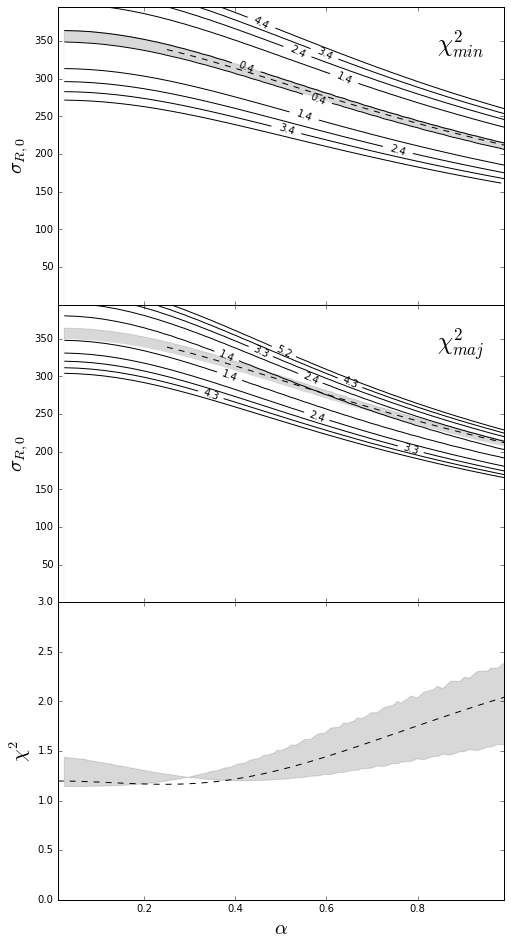

In [20]:
def main_slice(l):
    return sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

os.chdir("C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs")

alphas = np.arange(0.01, 1.2, 0.03)
sigmas = np.arange(100.0, 400, 3.)

import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
# levels = np.linspace(start=image_min.min(), stop=20., num=5)
# levels = [100., 125., 150., 175., 200.]
# levels = [image_min.min()+0.02, image_min.min()+0.4, image_min.min()+1.1, image_min.min()+2., 
#           image_min.min()+3.1, image_min.min()+4.1]
# levels = np.linspace(start=image_min.min()+0.1, stop=image_min.min()+4.1, num=5)
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
# im = ax.imshow(image_min, cmap='jet', vmin=image_min.min(), vmax=20., interpolation='spline16', 
#                    origin="lower", aspect="auto")
# plt.show()
cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()
v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 280, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
# ax.set_ylim(0, 400)
ax.set_xlim(0.01, 0.99)
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{min}$', size = 24.)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')

ax = axes[1]
# levels = np.linspace(start=image_maj.min()-4.3, stop=10., num=10)
# levels = [7., 10., 50., 100.]
# levels = [image_maj.min()+0.2, image_maj.min()+0.7, image_maj.min()+1.1, image_maj.min()+2.1, image_maj.min()+3.1, 
#           image_maj.min()+4.1]
levels = np.linspace(start=image_maj.min()+0.3, stop=image_maj.min()+4.1, num=5)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 280, '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
# ax.set_ylim(0, 400)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{maj}$', size = 24.)


ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

import scipy.interpolate as sp
try:
    f1 = sp.interp1d(x2, err_maj1, kind='linear')
    ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
except Exception:
    f2 = sp.interp1d(x1, err_maj2, kind='linear')
    ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)


ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

ax.set_ylim(0.0, 3.)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.01, 0.99)


plt.show()


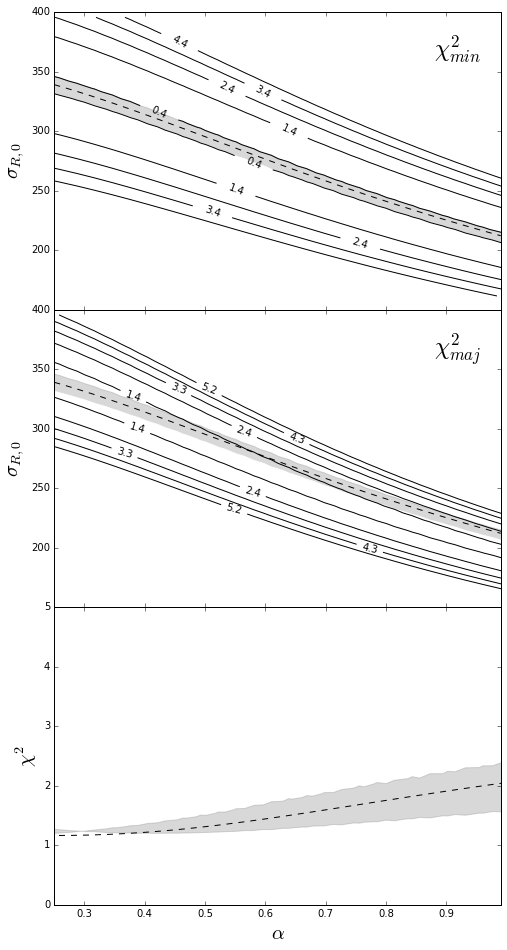

In [23]:
def main_slice(l):
    return sig_min_0/sqrt(sin_i**2 + cos_i**2 * l**2)

def calc_chi2_normal(obs, obserr, predicted):
    return sum([(o-p)**2/err**2 for (o,p,err) in zip(obs, predicted, obserr)])/len(obs)

os.chdir("C:\\Users\\root\\Dropbox\\RotationCurves\\PhD\\paper1\\text\\imgs")

alphas = np.arange(0.01, 1.2, 0.03)
sigmas = np.arange(100.0, 400, 3.)

import matplotlib.mlab as mlab
import matplotlib

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=[8,16])
ax = axes[0]
# levels = np.linspace(start=image_min.min(), stop=20., num=5)
# levels = [100., 125., 150., 175., 200.]
# levels = [image_min.min()+0.02, image_min.min()+0.4, image_min.min()+1.1, image_min.min()+2., 
#           image_min.min()+3.1, image_min.min()+4.1]
# levels = np.linspace(start=image_min.min()+0.1, stop=image_min.min()+4.1, num=5)
levels = np.linspace(start=image_min.min()*1.1, stop=image_min.min()*1.1+4, num=5)
# im = ax.imshow(image_min, cmap='jet', vmin=image_min.min(), vmax=20., interpolation='spline16', 
#                    origin="lower", aspect="auto")
# plt.show()
cset=ax.contour(image_min, levels,  colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
min_map_gutter = cset.collections[0].get_paths()
v1,v2 = min_map_gutter[1].vertices, min_map_gutter[0].vertices
x1,x2 = v1[:,0], v2[:,0]
y1,y2 = v1[:,1], v2[:,1]
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 280, '$\chi^2_{min}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.set_ylim(150, 400)
ax.set_xlim(0.25, 0.99)
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{min}$', size = 24.)


min_sigmas = np.where(image_min < image_min.min() + 0.03)
slice_alph, slice_sig = min_sigmas[1], min_sigmas[0]
slice_alph = map(lambda l: alphas[0] + (alphas[-1] - alphas[0])*l/len(image_min[0]) , slice_alph)
slice_sig = map(lambda l: sigmas[0] + (sigmas[-1] - sigmas[0])*l/len(image_min), slice_sig)
# ax.plot(slice_alph, slice_sig, '.', color='pink')
poly_slice = poly1d(polyfit(slice_alph, slice_sig, deg=3))
# ax.plot(xx, poly_slice(xx), '.-', color='black')

ax = axes[1]
# levels = np.linspace(start=image_maj.min()-4.3, stop=10., num=10)
# levels = [7., 10., 50., 100.]
# levels = [image_maj.min()+0.2, image_maj.min()+0.7, image_maj.min()+1.1, image_maj.min()+2.1, image_maj.min()+3.1, 
#           image_maj.min()+4.1]
levels = np.linspace(start=image_maj.min()+0.3, stop=image_maj.min()+4.1, num=5)
cset=ax.contour(image_maj, levels, hold='on', colors = 'k', origin='lower', extent=[alphas[0],alphas[-1],sigmas[0],sigmas[-1]])
plt.clabel(cset, inline=1, fontsize=10, fmt='%1.1f',)
# ax.text(0.87, 280, '$\chi^2_{maj}$', size = 24.)
ax.set_ylabel('$\sigma_{R,0}$', size=20.)
xx = np.arange(0.25, 1.0, 0.01)
ax.plot(xx, map(main_slice, xx), '--', color='black')
ax.fill_between(x1, y1, 0, color='gray', alpha=0.3)
ax.fill_between(x2, y2, 0, color='white')
ax.set_ylim(150, 400)
xlim, ylim = ax.get_xlim(), ax.get_ylim()
ax.text(0.85*(xlim[1]-xlim[0])+xlim[0], 0.85*(ylim[1]-ylim[0]) + ylim[0], '$\chi^2_{maj}$', size = 24.)


ax = axes[2]
err_maj = []
for al in alphas:
    global alpha, sig_R_0
    alpha = al
    sig_R_0 = main_slice(al)
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj.append(sqerr_maj)
ax.plot(alphas, err_maj, '--', color='black')
err_maj1 = []
for pa in zip(x2,y2):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj1.append(sqerr_maj)
# ax.plot(x2, err_maj1, '-', color='black')
err_maj2 = []
for pa in zip(x1,y1):
    global alpha, sig_R_0
    alpha = pa[0]
    sig_R_0 = pa[1]
    sqerr_maj = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    err_maj2.append(sqerr_maj)
# ax.plot(x1, err_maj2, '-', color='black')
ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

import scipy.interpolate as sp
try:
    f1 = sp.interp1d(x2, err_maj1, kind='linear')
    ax.fill_between(x1, map(f1, x1), err_maj2, color='grey', alpha=0.3)
except Exception:
    f2 = sp.interp1d(x1, err_maj2, kind='linear')
    ax.fill_between(x2, map(f2, x2), err_maj1, color='grey', alpha=0.3)


ax.set_ylabel(r'$\chi^2$', size=20.)
ax.set_xlabel(r'$\alpha$', size=20.)

ax.set_ylim(0.0, 5.)


fig.subplots_adjust(hspace=0.)
axes[0].yaxis.get_major_ticks()[0].set_visible(False)
axes[1].yaxis.get_major_ticks()[0].set_visible(False)
ax.set_xlim(0.25, 0.99)


plt.show()


N1_maj=48,	 N2_min=40,	 chi^2_corr[0][0]=60.0800703353 (was 36.8066054904 and 79.4746243727)


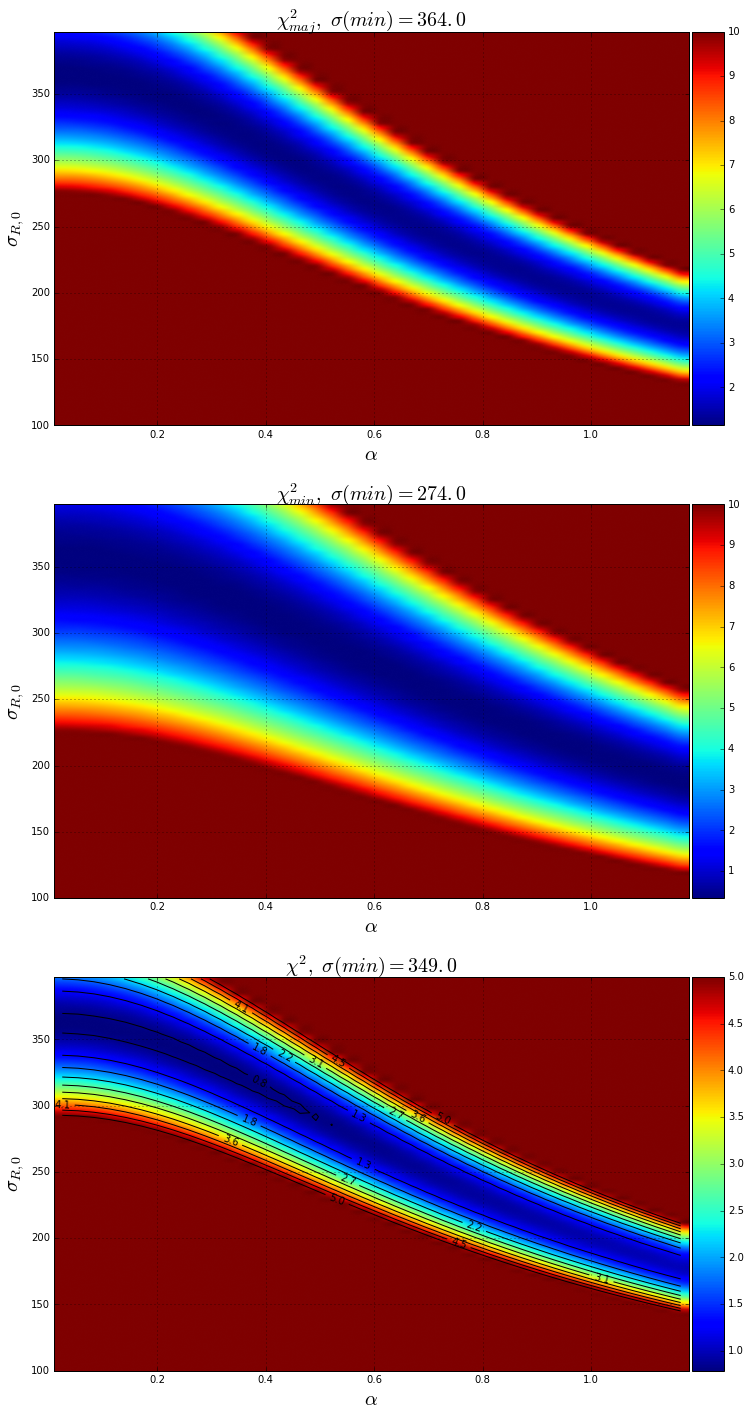

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=True, figsize=[12,24])
plot_chi2_map(image_maj, axes[0], log_scale=False, title='$\chi^2_{maj}$', is_contour=False, vmax=10.)
plot_chi2_map(image_min, axes[1], log_scale=False, title='$\chi^2_{min}$', is_contour=False, vmax=10.)
corr_image = (image_min*len(sig_min_p) + image_maj*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
print 'N1_maj={},\t N2_min={},\t chi^2_corr[0][0]={} (was {} and {})'.format(len(sig_maj_p), len(sig_min_p), corr_image[0][0], 
                                                                            image_min[0][0], image_maj[0][0])
plot_chi2_map(corr_image, axes[2], log_scale=False, title='$\chi^2$', is_contour=True, vmax=5.)
plt.show()

In [53]:
import scipy.optimize as opt

def chisqfunc((x_sig, x_alpha)):
    global sig_R_0, alpha
    sig_R_0 = x_sig
    alpha = x_alpha
    sqerr_ma = calc_chi2_normal(sig_maj_p, e_sig_maj_p, [sig_maj_exp(r) for r in radii_maj])
    sqerr_mi = calc_chi2_normal(sig_min_p, e_sig_min_p, [sig_min_exp(r) for r in radii_min])
    chisq = (sqerr_mi*len(sig_min_p) + sqerr_ma*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
    return chisq

x0 = np.array([100., 0.5])

res = opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B')
print res

      fun: 0.78461222340997883
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([  0.00000000e+00,   2.48689958e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 87
      nit: 21
   status: 0
  success: True
        x: array([  3.53429743e+02,   1.57229146e-01])


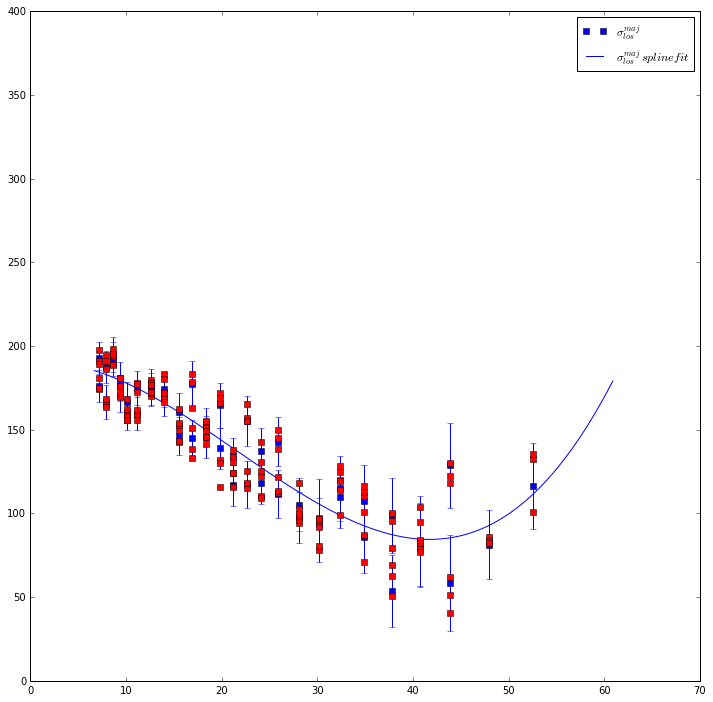

In [54]:
def gen_next_normal(radii, sig, esig):
    randomDelta =  np.array([np.random.normal(0., derr/2, 1)[0] for derr in esig] ) 
    randomdataY = sig + randomDelta
    return zip(radii, randomdataY)

plt.plot(radii_maj, sig_maj_p, 's', label='$\sigma_{los}^{maj}$', color='blue')
plt.errorbar(radii_maj, sig_maj_p, yerr=e_sig_maj_p, fmt='o', marker='.', color='blue')
plt.plot(points, poly_sig_maj(points), label = '$\sigma_{los}^{maj}\, splinefit$', color='blue')
 
for i in range(3):
    r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    plt.plot(r, s, 's', color='red')

plt.ylim(0., 400.)
plt.legend()
plt.show()

In [60]:
os.chdir("C:\\science\\2FInstability\\data\\ngc1167")
pics_path = '.cutted\\pics\\'
import time

alphas = np.arange(0.25, 0.6, 0.03)
sigmas = np.arange(100.0, 400, 3.)


N = 200000

result = []

start_time = time.time()


if not os.path.exists(pics_path):
    os.makedirs(pics_path)
if os.path.isfile(pics_path + 'monte_carlo_nm.npy'):
    result = np.load(pics_path + "monte_carlo_nm.npy")
else:
    for i in log_progress(range(N)):
        global poly_sig_maj, poly_sig_min
    #     r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
        poly_sig_maj = inter.UnivariateSpline(r, s, k=3, s=10000.)
    #     poly_sig_maj = poly1d(polyfit(r, s,  deg=9))

        r, s = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
        poly_sig_min = inter.UnivariateSpline(r, s, k=3, s=10000., w=w(e_sig_min_p))
    #     poly_sig_min = poly1d(polyfit(r, s,  deg=9))

        result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B').x,
                      poly_sig_maj.get_coeffs(), poly_sig_min.get_coeffs()))
#         result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (0., alphas[-1])], method='L-BFGS-B').x,
#                       poly_sig_maj.get_coeffs(), poly_sig_min.get_coeffs()))
    #     result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B').x,
    #                   poly_sig_maj.coeffs, poly_sig_min.coeffs))
    np.save(pics_path + 'monte_carlo_nm', np.array(result))

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.57299995422 seconds ---


In [61]:
len(result)

200000

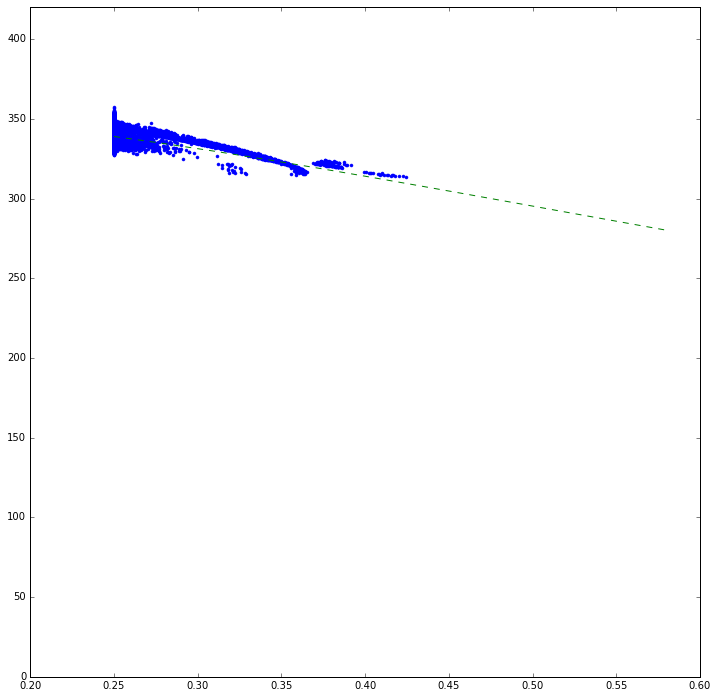

In [62]:
s, _, _ = zip(*result)
s,a = zip(*s)
# s1 = filter(lambda l: l[1] > 0.27, s)
# s,a = zip(*s1)
plt.plot(a, s, '.')
plt.plot(alphas, map(main_slice, alphas), '--')
# plt.xlim(0.0, 0.99)
plt.ylim(0, 420)
plt.show()

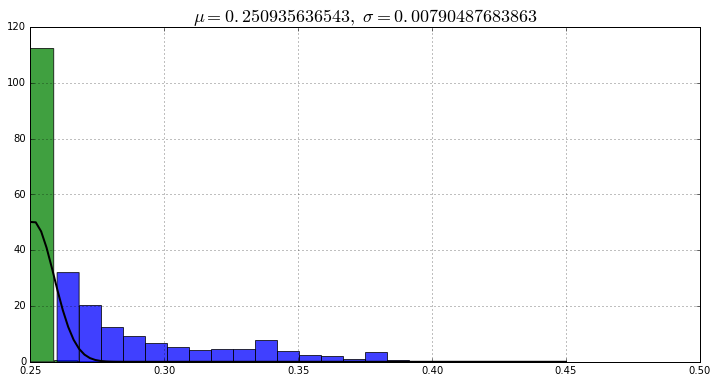

In [63]:
from scipy.stats import norm

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(a, 20, normed=1, facecolor='green', alpha=0.75)
mu, std = norm.fit(a)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

s1 = filter(lambda l: l[1] > 0.26, zip(*result)[0])
s,a = zip(*s1)
ax.hist(a, 20, normed=1, facecolor='blue', alpha=0.75)

ax.set_title('$\mu=%s,\ \sigma=%s$' % (mu, std), fontsize=18)
ax.grid(True)

plt.show()

In [29]:
os.chdir("C:\\science\\2FInstability\\data\\ngc1167")
pics_path = '.cutted\\pics\\'
import time

alphas = np.arange(0.1, 1.2, 0.03)
sigmas = np.arange(100.0, 400, 3.)
N = 3000
start_time = time.time()
mc_image = corr_image

for i in log_progress(range(N)):
    global poly_sig_maj, poly_sig_min
    r1, s1 = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
    r, s = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
    poly_sig_min = inter.UnivariateSpline(r, s, k=3, s=10000., w=w(e_sig_min_p))
    image_min_ = np.random.uniform(size=(len(sigmas), len(alphas)))
    image_maj_ = np.random.uniform(size=(len(sigmas), len(alphas)))
    for i,si in enumerate(sigmas):
        for j,al in enumerate(alphas):
            global alpha, sig_R_0
            alpha = al
            sig_R_0 = si
            sqerr_maj = calc_chi2_normal(s1, e_sig_maj_p, [sig_maj_exp(rr) for rr in r1])
            sqerr_min = calc_chi2_normal(s, e_sig_min_p, [sig_min_exp(rr) for rr in r])
            image_maj_[i][j] = sqerr_maj
            image_min_[i][j] = sqerr_min
    corr_image_ = (image_min_*len(sig_min_p) + image_maj_*len(sig_maj_p)) / (len(sig_min_p) + len(sig_maj_p))
    mc_image += corr_image_
    
print("--- %s seconds ---" % (time.time() - start_time))
mc_image = mc_image / N

--- 59837.141 seconds ---


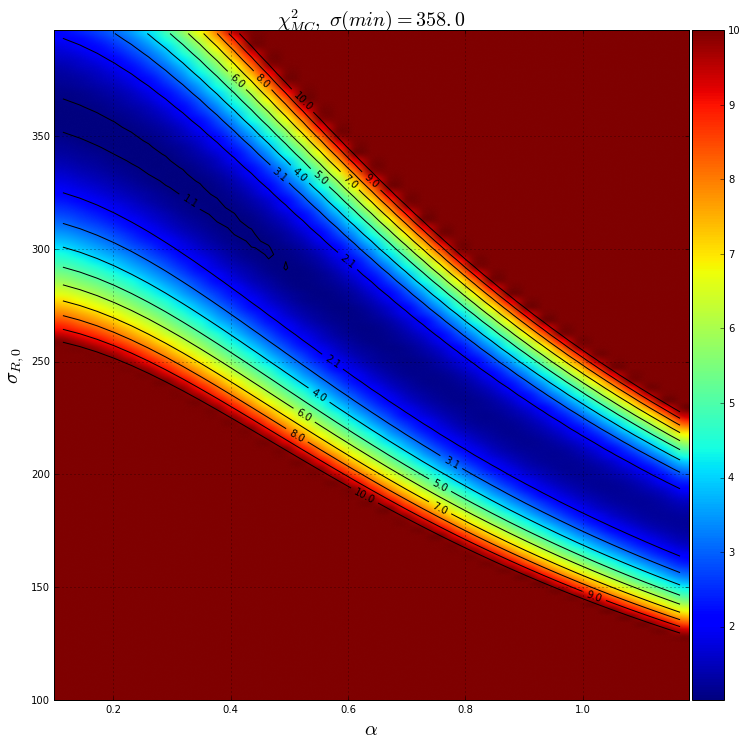

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=True, figsize=[12,12])
plot_chi2_map(mc_image, axes, log_scale=False, title='$\chi^2_{MC}$', is_contour=True, vmax=10.)
plt.show()

In [69]:
alphas = np.arange(0.1, 0.6, 0.03)
sigmas = np.arange(100.0, 400, 3.)


N = 25000

result = []

for i in log_progress(range(N)):
    global poly_sig_maj, poly_sig_min, sig_min_0
#     r, s = zip(*gen_next_normal(radii_maj, sig_maj_p, e_sig_maj_p))
#     poly_sig_maj = inter.UnivariateSpline(r, s, k=3, s=10000.)
#     poly_sig_maj = poly1d(polyfit(r, s,  deg=9))

    r, s = zip(*gen_next_normal(radii_min, sig_min_p, e_sig_min_p))
    poly_sig_min = inter.UnivariateSpline(r, s, k=3, s=10000., w=w(e_sig_min_p))
    sig_min_0 = poly_sig_min(cutted)
    
#     poly_sig_min = poly1d(polyfit(r, s,  deg=9))

    result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B').x,
                  poly_sig_maj.get_coeffs(), poly_sig_min.get_coeffs()))
#         result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (0., alphas[-1])], method='L-BFGS-B').x,
#                       poly_sig_maj.get_coeffs(), poly_sig_min.get_coeffs()))
#     result.append((opt.minimize(chisqfunc, x0, bounds=[(sigmas[0], sigmas[-1]), (alphas[0], alphas[-1])], method='L-BFGS-B').x,
#                   poly_sig_maj.coeffs, poly_sig_min.coeffs))


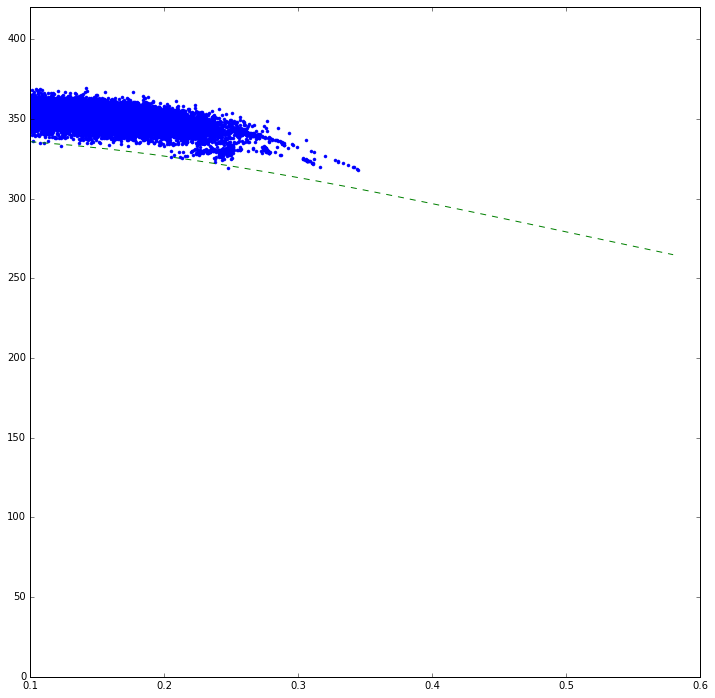

In [70]:
s, _, _ = zip(*result)
s1 = filter(lambda l: l[1] > 0.1, s)
s,a = zip(*s1)
plt.plot(a, s, '.')
plt.plot()
plt.plot(alphas, map(main_slice, alphas), '--')
plt.ylim(0, 420)
plt.show()

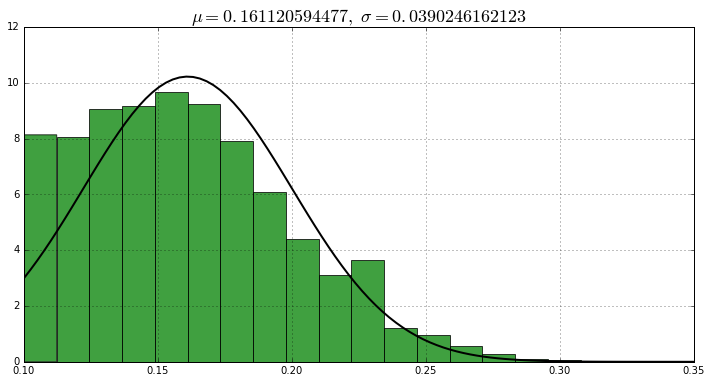

In [71]:
from scipy.stats import norm

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(a, 20, normed=1, facecolor='green', alpha=0.75)
mu, std = norm.fit(a)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# s1 = filter(lambda l: l[1] > 0.26, zip(*result)[0])
# s,a = zip(*s1)
# ax.hist(a, 20, normed=1, facecolor='blue', alpha=0.5)

ax.set_title('$\mu=%s,\ \sigma=%s$' % (mu, std), fontsize=18)
ax.grid(True)

plt.show()